In [1]:
"""
Expects a csv file with image id, maxlat, maxlon, minlat, minlon of each satellite image
Expects json files as a folder with the polygons parsed from the shapefile
Expects images for overlaying masks on images

"""

import json
import numpy as np
import pandas as pd
import sys
import os
import cv2
import imageio
import csv
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict 

import pyproj
from shapely.geometry import box, Polygon
from shapely.ops import transform
from functools import partial

# Helper functions

In [2]:
def create_empty_overlays(grid, orig_images_dir, prefix='', suffix='', n=100):
    """
    Initiate empty masks and original images into the output folder based on the
    
    Args:
        grid (list): information from csv, so the empty masks to be overwritten later
    """
    for index in range(len(grid.keys())):
        image_id = str(grid[index]['image_id']).zfill(5)
        if image_id >= str(n).zfill(5):
            break
            
        im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + '.tif')
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)

def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

def scale_coords(shape_size, geom, grid, index):
    """
    scales the polygons lat/lon to pixel 
    Args:
        shape_size (tuple): size of the image to be scaled to
        geom (polygon): field polygon
        grid (list): values of min/max lat/lon for each image id
        index (int): Index of each image id in grid

    Returns:
        list: scaled coordinates
    """
    w, h = shape_size
    min_lat, min_lon, max_lat, max_lon = grid[index]['min_lat'], grid[index]['min_lon'], \
        grid[index]['max_lat'], grid[index]['max_lon']
    
    # transform to EPSG 3857
    poly = Polygon(geom)
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:3857')) # destination coordinate system

    poly2 = transform(project, poly)
    
    # x = geom[:,0]
    # y = geom[:,1]
    x = np.array(poly2.exterior.xy[0])
    y = np.array(poly2.exterior.xy[1])
    scale_lon = w / (max_lon - min_lon)
    scale_lat = h / (max_lat - min_lat)
    scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
    scaled_y = h - ((y - min_lat) * scale_lat)
    if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) \
        or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
        return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
    return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

# Setup

In [3]:
def get_grid(df):
    """
    Read the CSV file containing minmax lat/lon and stores it to a 2D list

    Args:
        df: pandas dataframe of bounding boxes

    Returns:
        list: contains the imag_id and lat/long information
    """
    grid = dict()
    keys = ['max_lat', 'max_lon', 'min_lat', 'min_lon']

    for index, row in df.iterrows():
        if index not in grid:
            grid[index] = dict()
        grid[index]['image_id'] = row['image_id']
        grid[index]['max_lat'] = float(row['max_lat'])
        grid[index]['max_lon'] = float(row['max_lon'])
        grid[index]['min_lat'] = float(row['min_lat'])
        grid[index]['min_lon'] = float(row['min_lon'])
        
    return grid

In [9]:
# ======================== USER SETUP ======================== #b
# Directories to read the necessary files from
year_month = '_2019_04'
thickness = 2 # 6
downsample = 1 # 3
n_to_sample = 100
n_images = 100

base_dir = '../data/planet/france/' # sherrie10k/'

label_folder = 'extent_labels/1250px/original_thickness{}_for_IoU'.format(thickness)
# label_folder = 'extent_labels/1250px_{}field/original_thickness{}'.format(n_to_sample, thickness)

overlay_folder = 'overlays/1250px_{}field'.format(n_to_sample)
# overlay_folder = 'overlays/1250px'

# csv_file = os.path.join(base_dir, 'bbox10k_1250px.csv')
csv_file = os.path.join(base_dir, 'bbox_1250px_epsg3857.csv')

# orig_images_dir = '../mount/data/planetData/france/sherrie10k/1250px/'
# orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', '1250px', '3x_downsample', '2019_10')
# orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', '1250px', 'original', '2019_04')
orig_images_dir = os.path.join(base_dir, '1250px', 'original/')
# ============================================================ #

df = pd.read_csv(csv_file)
df = df.rename({'min_x': 'min_lon', 'max_x': 'max_lon', 'min_y': 'min_lat', 'max_y': 'max_lat'}, axis=1)
df['image_id'] = df['image_id'].astype(str).str.zfill(5)
grid = get_grid(df)

# Run label generation

In [6]:
# create output directory if not exist
if os.path.exists(os.path.join(base_dir, label_folder)) == False:
    os.makedirs(os.path.join(base_dir, label_folder))
if os.path.exists(os.path.join(base_dir, overlay_folder)) == False:
    os.makedirs(os.path.join(base_dir, overlay_folder))

In [6]:
# create_empty_overlays(grid, orig_images_dir, suffix='_2019_10')

KeyboardInterrupt: 

### 1250px tiles

In [22]:
splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
train_ids = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
test_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values

In [26]:
# json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') 
#                      if 'bbox10k_1250px_' in x])
json_files = sorted([x for x in os.listdir('../data/planet/france/json_polys/') if 'bbox10k_1250px_' in x])
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]

for json_name in json_files:
    json_file = os.path.join('../data/planet/france/json_polys/', json_name)

    count_parcels = defaultdict(int)
    num_fields_parsed = 0

    # read multiple json files
    print('Read json', json_file)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    # find the polygons of each image and plot them
    start = int(json_name.split('_')[2]) * 1000
    end = start + 1000

    for index in range(len(grid.keys())):
        if index < start:
            continue

        if index >= end:
            break

        image_id = grid[index]['image_id']
        if int(image_id) % 10 == 0:
            print(image_id)
        polys = []
        if (image_id in parcels_dict) and ((image_id in val_ids) or (image_id in test_ids)):
            img = imageio.imread(os.path.join(orig_images_dir, image_id + year_month + '.tif'))
            shape_size = (img.shape[0], img.shape[1])
            extent_path = os.path.join(base_dir, label_folder, str(image_id) + '.npy') # '.png')
            extent_label = np.zeros(shape_size)

            field_count = 1
            for sh_index, sh in enumerate(parcels_dict[image_id]):
                count_parcels[image_id] += 1
                # if int(sh['properties']['CODE_GROUP']) in codes_to_keep:
                for coord_idx in range(len(sh['geometry']['coordinates'])):
                    geom = np.array(sh['geometry']['coordinates'][coord_idx])
                    try:
                        geom_fixed = scale_coords(shape_size, geom, grid, index)
                    except:
                        print("Exception in image {}".format(image_id))
                        print(geom)
                    pts = geom_fixed.astype(int)
                    cv2.fillPoly(extent_label, [pts], color=field_count)
                    polys.append(pts)
                    field_count += 1

            # Save the extent label
            # extent_label = cv2.imread(extent_path, cv2.IMREAD_UNCHANGED)
            cv2.polylines(extent_label, polys, True, color=0, thickness=thickness)
            # cv2.imwrite(extent_path, extent_label)
            np.save(extent_path, np.array(extent_label, dtype=np.uint16))

            # Saves the overlay file
#             if image_id < '00100':
#                 overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
#                 orig_image = cv2.imread(overlay_path)
#                 cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
#                 cv2.imwrite(overlay_path, orig_image)
                # print('saved image ', image_id)

    # save a small summary of number of parcels in each image
#     if start == 0:
#         open_mode = 'w'
#     else:
#         open_mode = 'a'
#     with open(os.path.join(base_dir, 'json_polys', 'parcel_in_image_count_1250px.csv'), open_mode) as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['image_id', 'count'])
#         for key, value in count_parcels.items():
#             writer.writerow([int(key), value])

Read json ../data/planet/france/json_polys/bbox10k_1250px_0_285237.json
00000
00010
00020
00030
00040
00050
00060
00070
00080
00090
00100
00110
00120
00130
00140
00150
00160
00170
00180
00190
00200
00210
00220
00230
00240
00250
00260
00270
00280
00290
00300
00310
00320
00330
00340
00350
00360
00370
00380
00390
00400
00410
00420
00430
00440
00450
00460
00470
00480
00490
00500
00510
00520
00530
00540
00550
00560
00570
00580
00590
00600
00610
00620
00630
00640
00650
00660
00670
00680
00690
00700
00710
00720
00730
00740
00750
00760
00770
00780
00790
00800
00810
00820
00830
00840
00850
00860
00870
00880
00890
00900
00910
00920
00930
00940
00950
00960
00970
00980
00990
Read json ../data/planet/france/json_polys/bbox10k_1250px_1_304170.json
01000
01010
01020
01030
01040
01050
01060
01070
01080
01090
01100
01110
01120
01130
01140
01150
01160
01170
01180
01190
01200
01210
01220
01230
01240
01250
01260
01270
01280
01290
01300
01310
01320
01330
01340
01350
01360
01370
01380
01390
01400
01410
0142

In [21]:
# delete the training set ones for now
for train_id in train_ids:
    iou_label_path = os.path.join(base_dir, label_folder, str(train_id) + '.npy')
    if os.path.exists(iou_label_path):
        os.remove(iou_label_path)

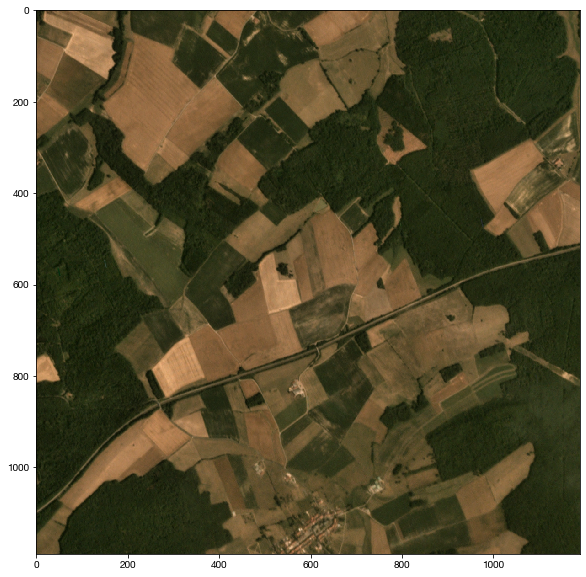

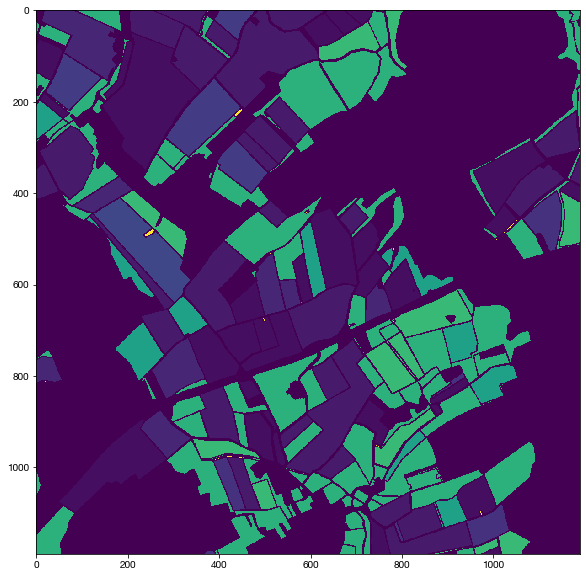

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img = imageio.imread('../data/planet/france/1250px/09909_2019_07.tif')
ax.imshow(img)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
label = imageio.imread('../data/planet/france/extent_labels/1250px/original_thickness2/09909.png')
ax.imshow(label)
plt.show()

# Verify labels

### 1250px

In [ ]:
'../data/planet/france/sherrie10k/extent_labels/1250px/original_thickness12/'

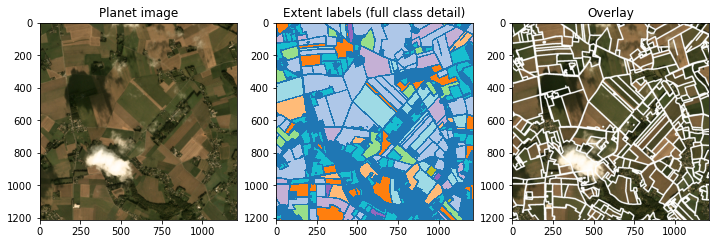

In [15]:
# thickness 8
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '00001'

mask = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/1250px/original/2019_10/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='tab20', interpolation='nearest', vmin=0, vmax=19)
ax[1].set_title('Extent labels (full class detail)')

overlay = imageio.imread('../data/planet/france/sherrie10k/overlays/1250px/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

In [32]:
np.unique(cv2.resize(extent, (img_size_rows, img_size_cols), interpolation=cv2.INTER_NEAREST))

array([ 0, 17, 18], dtype=uint8)

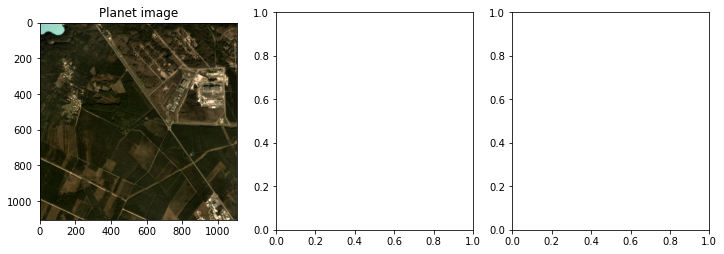

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '00109'

mask = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/1250px/original/2019_10/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px/original_thickness4/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='tab20', interpolation='nearest', vmin=0, vmax=19)
ax[1].set_title('Extent labels (full class detail)')

# overlay = imageio.imread('../data/planet/france/sherrie10k/overlays/{}.jpeg'.format(image_id))
# ax[2].imshow(overlay)
# ax[2].set_title('Overlay')

plt.show()

# Which crop classes do we want to segment fields for?

In [20]:
crop_coding = pd.read_csv('../mount/data/france_parcels/Codification_cultures_principales_2019.csv')

In [23]:
crop_coding.head()

,Code Culture,Libellé Culture,Code Groupe Culture,Libellé Groupe Culture,Culture group
0,BTH,Blé tendre d’hiver,1,Blé tendre,soft wheat
1,BTP,Blé tendre de printemps,1,Blé tendre,soft wheat
2,MID,Maïs doux,2,Maïs grain et ensilage,grain corn and silage
3,MIE,Maïs ensilage,2,Maïs grain et ensilage,grain corn and silage
4,MIS,Maïs,2,Maïs grain et ensilage,grain corn and silage


In [24]:
crop_coding.groupby(['Code Groupe Culture', 'Culture group']).size()

Code Groupe Culture  Culture group                             
1                    soft wheat                                      2
2                    grain corn and silage                           3
3                    barley                                          2
4                    other grains                                   29
5                    rapeseed                                        2
6                    sunflower                                       1
7                    other oilseeds                                 14
8                    high-protein legumes                           13
9                    fiber plants                                    3
11                   frost (frozen surfaces without production)      4
14                   rice                                            1
15                   grain pulses                                    2
16                   feed                                          106
17           

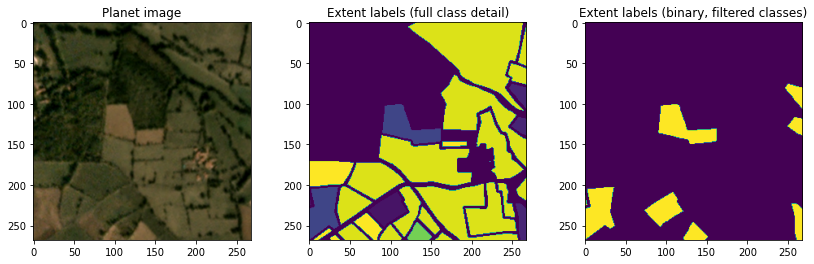

In [33]:
codes_to_keep = [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 26]

image_id = '00000'
img = imageio.imread(
    '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/2019_10/{}_2019_10.tif'.format(image_id))
extent = imageio.imread('../data/planet/france/sherrie10k/extent_labels/{}.png'.format(image_id))

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].imshow(img)
ax[1].imshow(extent)
ax[2].imshow(np.isin(extent, codes_to_keep))

ax[0].set_title('Planet image')
ax[1].set_title('Extent labels (full class detail)')
ax[2].set_title('Extent labels (binary, filtered classes)')

plt.show()